In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pprint import pprint
import pickle
import time
import datetime

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
# from qiskit.tools.monitor import job_monitor
from qiskit.compiler import transpile
from qiskit.transpiler.passes import RemoveBarriers

In [3]:
# Import state tomography modules
from qiskit_experiments.library import StateTomography
from osp_solutions.patch_ignis import rename_qcs_StateTomography_to_ignis
from osp_solutions.tomography import StateTomographyFitter
from qiskit.quantum_info import state_fidelity

In [4]:
from osp_solutions.circuits import append_block_trotter, append_block_trotter_proposed, append_initial_state

In [5]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error
# from qiskit_ibm_runtime.fake_provider import FakeJakartaV2
# backend = AerSimulator.from_backend(FakeJakartaV2())
# backend = Aer.get_backend("qasm_simulator")
p_dep1 = 0 # 1.0 * 1e-4
error_dep1 = pauli_error([("I", 1 - 3 * p_dep1 / 4), ("X", p_dep1 / 4), ("Y", p_dep1 / 4), ("Z", p_dep1 / 4)])
# error_dep2_local = error_dep1.tensor(error_dep1)

p_dep2 = 0 # 1.0 * 1e-3
error_dep2_global = pauli_error([("II", 1 - 15 * p_dep2 / 16), ("IX", p_dep2 / 16), ("IY", p_dep2 / 16), ("IZ", p_dep2 / 16),
                                 ("XI", p_dep2 / 16), ("XX", p_dep2 / 16), ("XY", p_dep2 / 16), ("XZ", p_dep2 / 16),
                                 ("YI", p_dep2 / 16), ("YX", p_dep2 / 16), ("YY", p_dep2 / 16), ("YZ", p_dep2 / 16),
                                 ("ZI", p_dep2 / 16), ("ZX", p_dep2 / 16), ("ZY", p_dep2 / 16), ("ZZ", p_dep2 / 16)])

# print(error_dep2_global)

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_dep1, ["rx", "rz", "sx", "h", "sdg", "s", "x", "u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_dep2_global, ["cz"])
# noise_model.add_all_qubit_quantum_error(error_3, ["cswap", "ccx"])
print(noise_model)
print()

# Create noisy simulator backend
simulator_noisy = AerSimulator(method="density_matrix",
                               noise_model=noise_model)

NoiseModel: Ideal



In [6]:
from osp_solutions.simulator_dm import make_dm_binary, hamiltonian_to_dm, DMExtended
from osp_solutions.hamiltonian import Hamiltonian, make_H_Heisenberg

In [7]:
num_qubits = 5

# The final time of the state evolution
time_evolution = np.pi

# Parameterize variable t to be evaluated at t=pi later
dt = Parameter('t')

# initial layout
# initial_layout = [5,3,1]
initial_layout = list(range(num_qubits))

# Number of trotter steps
num_steps_list = [4,10,50,100,200] # ,20,30,40,50] # ,60,70,80,90,100]
# num_steps_list = [100]
print("trotter step list: ", num_steps_list)

# scale_factors = [1.0, 2.0, 3.0] # unused for this file

shots = 1 << 13
reps = 1

state_initial_str = "11010"
state_initial_dm = DMExtended(matrix=make_dm_binary(state_initial_str, 
                                                    endian_binary="little_endian", 
                                                    endian_dm="big_endian"))

H_Heisenberg = make_H_Heisenberg(num_qubits=num_qubits)
matrix_Heisenberg = hamiltonian_to_dm(hamiltonian=H_Heisenberg)

U_Heisenberg = DMExtended(sp.linalg.expm(-1.0j * matrix_Heisenberg * time_evolution))

state_target_dm = state_initial_dm.apply_unitary(U_Heisenberg)
state_target_dm.is_valid()

trotter step list:  [4, 10, 50, 100, 200]


True

In [ ]:
raw_fid_list = []
raw_stddev_list = []

for num_steps in num_steps_list:
    
    print("trotter steps: ", num_steps)
    t1 = time.perf_counter()
    
    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(num_qubits, 
                         name="q")
    qc = QuantumCircuit(qr)

    # Prepare initial state
    append_initial_state(qc=qc, 
                         state_initial_str=state_initial_str)

    append_block_trotter(qc=qc, 
                         dt=dt, 
                         num_steps=num_steps)

    # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
    qc = qc.assign_parameters({dt: time_evolution / num_steps})
    print("created qc")

    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = StateTomography(qc).circuits()  #! state tomography requires === BIG ENDIAN === 
    st_qcs = rename_qcs_StateTomography_to_ignis(st_qcs)
    print("created st_qcs (length:", len(st_qcs), ")")

    # remove barriers
    st_qcs = [RemoveBarriers()(qc) for qc in st_qcs]
    print("removed barriers from st_qcs")

    # optimize circuit
    t3_st_qcs = transpile(st_qcs, optimization_level=3, basis_gates=["sx", "cx", "rz"])
    t3_st_qcs = transpile(t3_st_qcs, optimization_level=3, basis_gates=["sx", "cx", "rz"])
    print("created t3_st_qcs (length:", len(t3_st_qcs), ")")
    
    ### execute circuits, 8 iterations
    raw_fids = []
    for _ in range(reps):
        raw_results = simulator_noisy.run(t3_st_qcs,
                                          shots=shots,
                                         ).result()
        raw_rho = StateTomographyFitter(raw_results, 
                                        t3_st_qcs).fit(method='lstsq')
        raw_fids.append(state_fidelity(raw_rho, state_target_dm))

    raw_fid_list.append(np.mean(raw_fids))
    raw_stddev_list.append(np.std(raw_fids))
    
    t2 = time.perf_counter()
    print('raw state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(raw_fids), np.std(raw_fids)))
    print("time:", t2 - t1)
    print()

trotter steps:  4
created qc
created st_qcs (length: 243 )
removed barriers from st_qcs
created t3_st_qcs (length: 243 )
raw state tomography fidelity = 0.1872 ± 0.0000
time: 5.98498537496198

trotter steps:  10
created qc
created st_qcs (length: 243 )
removed barriers from st_qcs
created t3_st_qcs (length: 243 )
raw state tomography fidelity = 0.0899 ± 0.0000
time: 8.036291167023592

trotter steps:  50
created qc
created st_qcs (length: 243 )
removed barriers from st_qcs
created t3_st_qcs (length: 243 )
raw state tomography fidelity = 0.2726 ± 0.0000
time: 23.575954667059705

trotter steps:  100
created qc
created st_qcs (length: 243 )
removed barriers from st_qcs
created t3_st_qcs (length: 243 )
raw state tomography fidelity = 0.2734 ± 0.0000
time: 44.044623292051256

trotter steps:  200
created qc
created st_qcs (length: 243 )
removed barriers from st_qcs
created t3_st_qcs (length: 243 )
raw state tomography fidelity = 0.2729 ± 0.0000
time: 89.46676895802375



In [ ]:
with open("run_trotter_"+str(num_qubits)+"-qubit.pkl", "wb") as f:
    pickle.dump({"num_steps_list": num_steps_list, "fid": raw_fid_list, "stddev": raw_stddev_list}, f)

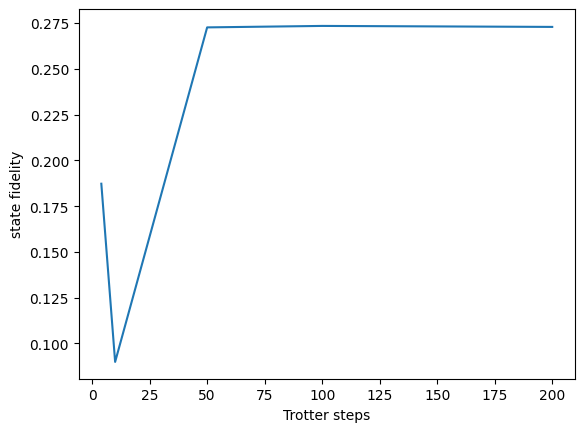

In [9]:
plt.plot(num_steps_list, raw_fid_list)
plt.xlabel("Trotter steps")
plt.ylabel("state fidelity")
plt.show()

In [11]:
# qc.draw("mpl")

In [12]:
# t3_st_qcs[0].draw("mpl")

In [13]:
print(simulator_noisy)

AerSimulator('aer_simulator_density_matrix')
